In [ ]:
!pip install qiskit

     |████████████████████████████████| 6.5 MB 5.3 MB/s 
     |████████████████████████████████| 18.0 MB 2.1 MB/s 
     |████████████████████████████████| 238 kB 44.5 MB/s 
     |████████████████████████████████| 200 kB 39.6 MB/s 
     |████████████████████████████████| 54 kB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 7.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.7 MB/s 
     |████████████████████████████████| 37.5 MB 68.2 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 943 kB 50.4 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 3.6 MB 36.3 MB/s 
     |████████████████████████████████| 113 kB 59.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.2-py3-none-any.whl size=11805 sha256=e0d65e4464e76db877595b05bd227b94436db29f119b93032b7618f2b5873044
  Stored in directory: /root/.cache/pip/wheels/62/77/65/cda6eedfdd2a525bd3f479a4386930ae3088a1eb01f8c9

In [ ]:
!pip install qiskit_machine_learning

     |████████████████████████████████| 118 kB 5.1 MB/s 


**Superposition**, **quantum measurement**, and **entanglement** are three phenomena that are central to quantum computing.if you are a quantum particle, then you can have a certain probability of facing left AND a certain probability of facing right due to a phenomenon known as superposition (also known as coherence).

A quantum particle such as an electron has its own “facing left or facing right” properties, for example spin, referred to as either up or down, or to make it more relatable to classical binary computing, let’s just say 1 or 0. When a quantum particle is in a superposition state, it’s a linear combination of an infinite number of states between 1 and 0, but you don’t know which one it will be until you actually look at it, which brings up our next phenomenon, quantum measurement.

In [ ]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

# declare quantum instance
qi = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

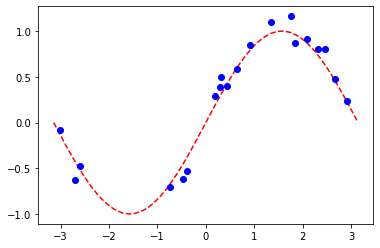

In [ ]:
# Generate random dataset

np.random.seed(0)
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb)*np.random.rand(num_samples, 1) + lb
y = f(X) + eps*(2*np.random.rand(num_samples, 1)-1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')
plt.plot(X, y, 'bo')
plt.show()

We create the circuit. The fundamental element of quantum computing is the quantum circuit. A quantum circuit is a computational routine consisting of coherent quantum operations on quantum data, such as qubits. It is an ordered sequence of quantum gates, measurements and resets, which may be conditioned on real-time classical computation. A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as as sequence of gates in the set. Any quantum program can be represented by a sequence of quantum circuits and classical near-time computation. A quantum circuit is a computational routine consisting of coherent quantum operations on quantum data, such as qubits, and concurrent real-time classical computation. It is an ordered sequence of quantum gates, measurements and resets, all of which may be conditioned on and use data from the real-time classical computation.

A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set. Any quantum program can be represented by a sequence of quantum circuits and non-concurrent classical computation.

The quantum circuit uses three qubits and two classical bits. There are four main components in this quantum circuit.

Initialization and reset 
First, we need to start our quantum computation with a well-defined quantum state. This is achieved using the initialization and reset operations. The resets can be performed by a combination of single-qubit gates and concurrent real-time classical computation that monitors whether we have successfully created the desired state through measurements. The initialization of  q
into a desired state  |ψ⟩ can then follow by applying single-qubit gates.

Quantum gates 
Second, we apply a sequence of quantum gates that manipulate the three qubits as required by the teleportation algorithm. In this case, we only need to apply single-qubit Hadamard (H) and two-qubit Controlled-X (⊕) gates.

Measurements 
Third, we measure two of the three qubits. A classical computer interprets the measurements of each qubit as classical outcomes (0 and 1) and stores them in the two classical bits.

Classically conditioned quantum gates 
Fourth, we apply single-qubit  Z and  X quantum gates on the third qubit. These gates are conditioned on the results of the measurements that are stored in the two classical bits. In this case, we are using the results of the classical computation concurrently in real-time within the same quantum circuit.

The act of observing or measuring a quantum particle collapses the superposition state (also known as decoherence) and the particle takes on a classical binary state of either 1 or 0.

In [ ]:
# Construct simple feature map
param_x = Parameter('x')
feature_map = QuantumCircuit(1, name='fm')
feature_map.ry(param_x, 0)

# Construct simple feature map
param_y = Parameter('y')
ansatz = QuantumCircuit(1, name='vf')
ansatz.ry(param_y, 0)

# Construct QNN
qnn3 = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=qi)
print(qnn3.operator)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
# Set seed for random dataset
np.random.seed(7)
initial_weights = 0.1*(2*np.random.rand(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


In [ ]:
# Define optimizer and loss function
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction='sum')

# Start training
model3.train()   # set model to training mode

# Define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)        # Initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()                              # Backward pass
    print(loss.item())                           # Print loss
    return loss

# Run optimizer
optimizer.step(closure)

21.262964248657227
3.3382768630981445
20.620962142944336
2.447436809539795
25.977062225341797
3.206045627593994
13.661500930786133
25.774295806884766
21.07257080078125
5.010274410247803
1.3200629949569702
0.25994038581848145
0.24564915895462036
0.24564766883850098


tensor(21.2630, grad_fn=<MseLossBackward0>)

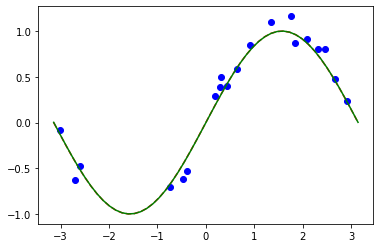

In [ ]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')

# Plot data
plt.plot(X, y, 'bo')

# Plot fitted line
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, 'g-')
plt.show()